In [1]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

/scratch/local/7379451/ipykernel_89451/2258313207.py:1: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/7379451/ipykernel_89451/2258313207.py:1: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will be removed in the future. Instead, please use `from photutils.psf import EPSFBuilder` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/7379451/ipykernel_89451/2258313207.py:1: DeprecationWarning: `photutils.find_peaks` is a deprecated alias for `photutils.detection.find_peaks` and will be removed in the future. Instead, please use `from photutils.detection import find_peaks` to 

In [2]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [3]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [4]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [5]:
import regions
from astropy.io import fits

In [6]:
cd /orange/adamginsburg/jwst/brick/F405N/pipeline/

/blue/adamginsburg/adamginsburg/jwst/brick/mastDownload/JWST/F405N/pipeline


In [70]:
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/overlapref.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/detectoroverlap_problemzone2.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/middle.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/topleft.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/topright.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/bottomleft.reg')
#reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/bottomright.reg')

reg = regions.Regions.read('/orange/adamginsburg/jwst/cloudc/regions/nrcb_try.reg')

In [71]:
import glob

In [82]:
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*_cal.fits")
files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*destreak.fits")
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*realigned.fits")
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*realigned_to_vvv.fits")
#files = glob.glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*tweakregstep.fits")
#files = glob.glob('/blue/adamginsburg/adamginsburg/jwst/cloudc/reduction/brick-jwst-2221/reduction/*_destreak_tweakregstep.fits')
#files = glob.glob('/blue/adamginsburg/adamginsburg/jwst/cloudc/reduction/brick-jwst-2221/reduction/*jhat.fits')

len(files), files[:3]

(32,
 ['/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00004_nrcblong_destreak.fits',
  '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00001_nrcblong_destreak.fits',
  '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_08201_00001_nrcalong_destreak.fits'])

In [83]:
import warnings

In [84]:
fits.open(files[0])


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b0fe5ac58e0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x2b0fe5a44f70>, <astropy.io.fits.hdu.image.ImageHDU object at 0x2b0fe5a360d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x2b0fe5a36310>, <astropy.io.fits.hdu.image.ImageHDU object at 0x2b0fe5a36550>, <astropy.io.fits.hdu.image.ImageHDU object at 0x2b0fe5a367f0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x2b0fe5a36a30>, <astropy.io.fits.hdu.image.ImageHDU object at 0x2b0fe5a36c70>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b0fe59c2a90>]

In [85]:
reg[0].to_pixel(wcs.WCS(fits.getheader(files[0], ext=1))).to_mask()

Set DATE-AVG to '2023-04-15T16:03:31.669' from MJD-AVG.
Set DATE-END to '2023-04-15T16:03:58.511' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.213224 from OBSGEO-[XYZ].
Set OBSGEO-H to 1299094589.651 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [86]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    masks = [reg[0].to_pixel(wcs.WCS(fits.getheader(fn, ext=1))).to_mask() for fn in files]
    shapes = [fits.getdata(fn, ext=1).shape for fn in files]
    cutouts = [mask.cutout(fits.getdata(fn, ext=1)) for mask,fn in zip(masks, files)]

In [87]:
len(cutouts)

32

In [88]:
import numpy as np

In [89]:
len([c for c in cutouts if np.any(c)])

8

In [90]:
tbl = Table.read('/orange/adamginsburg/jwst/cloudc/catalogs/jw02221-o002_t001_nircam_clear-F405N-merged_vvvcat.ecsv')
crds = tbl['skycoord']
crds_in = crds[reg[0].contains(crds, wcs=wcs.WCS(fits.getheader(files[0], ext=1)))]

Set DATE-AVG to '2023-04-15T16:03:31.669' from MJD-AVG.
Set DATE-END to '2023-04-15T16:03:58.511' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.213224 from OBSGEO-[XYZ].
Set OBSGEO-H to 1299094589.651 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


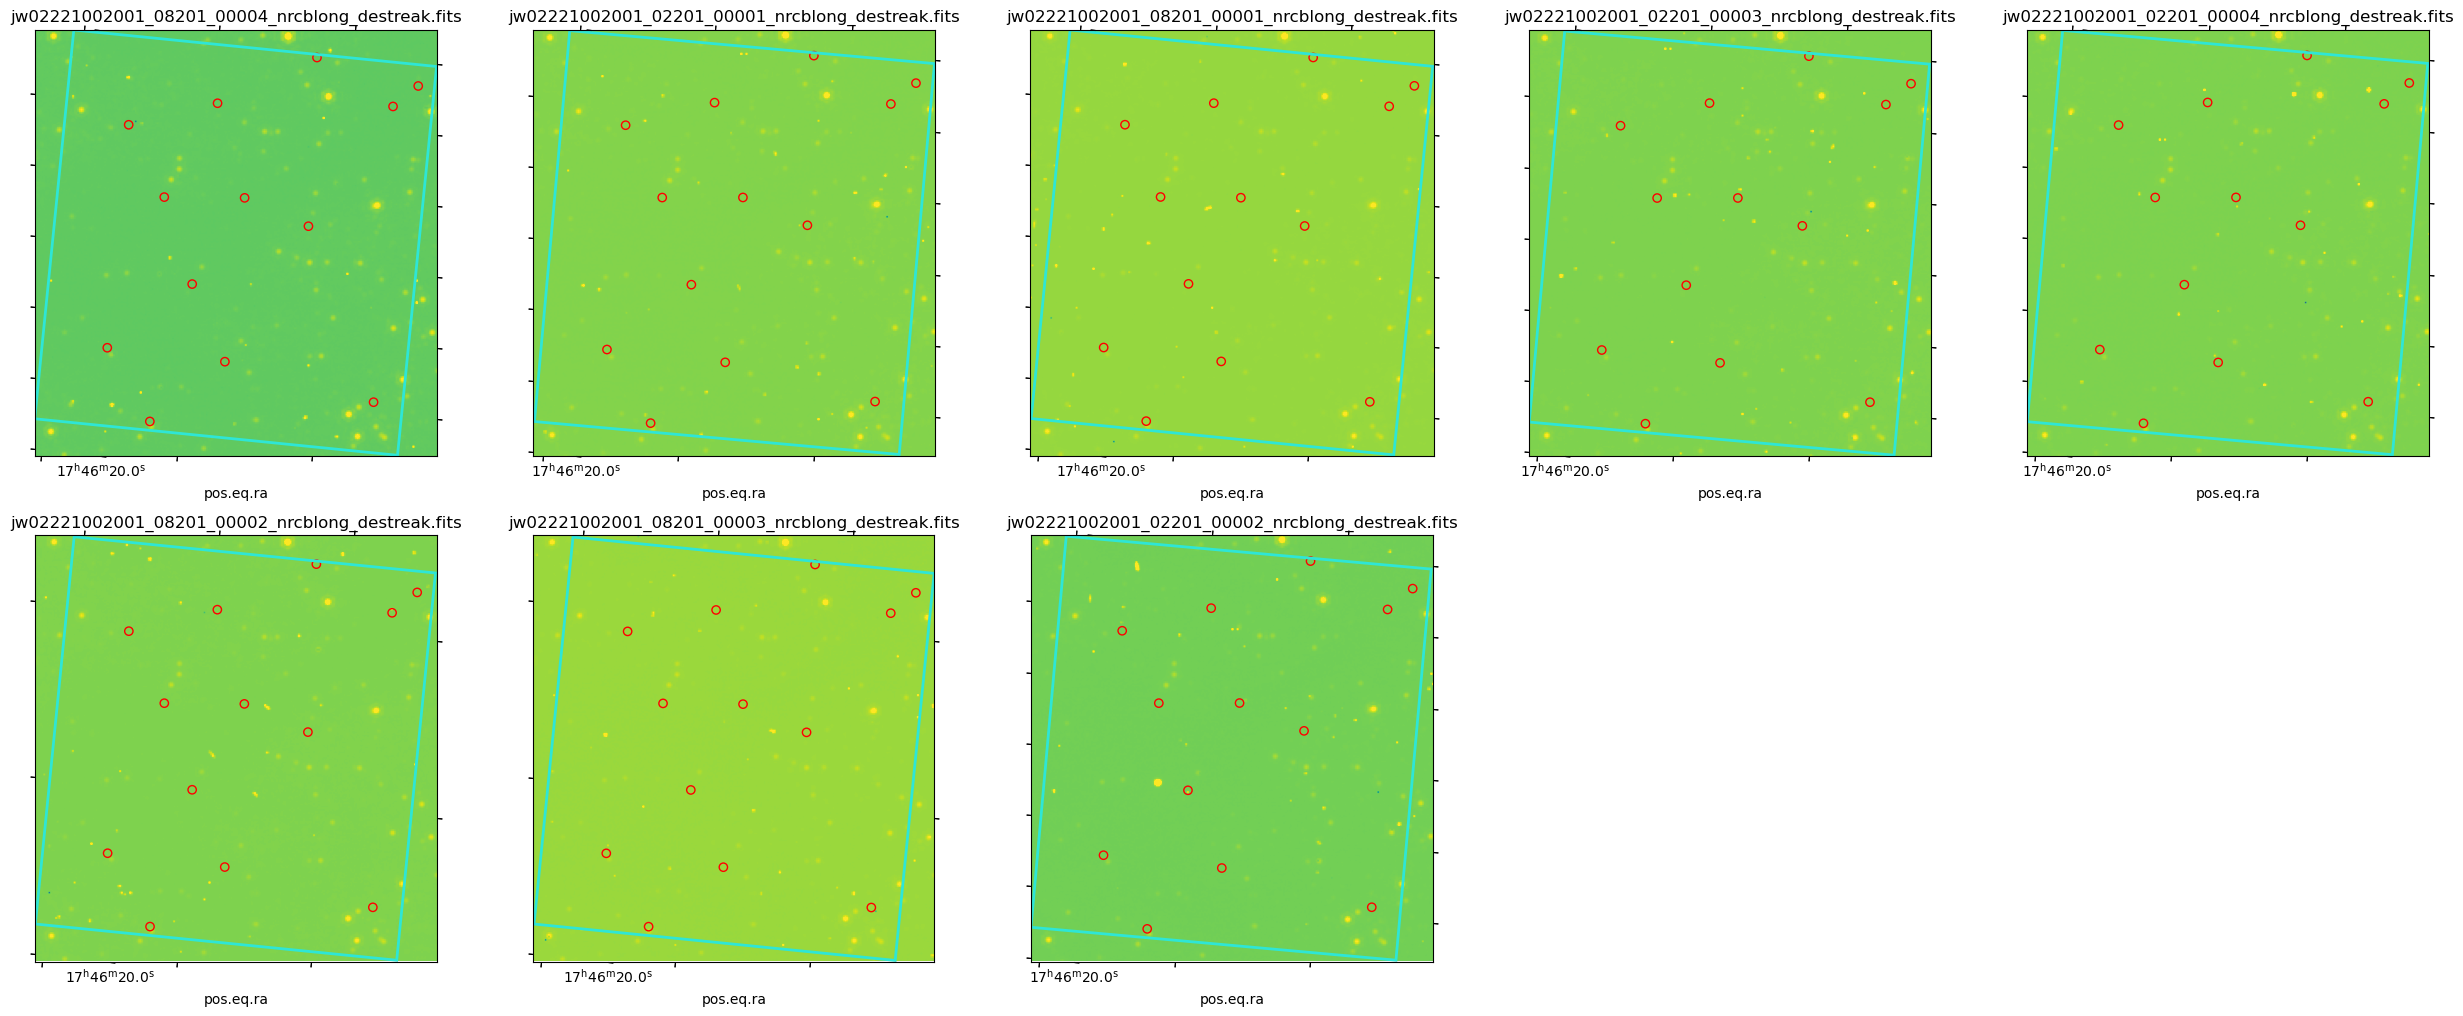

In [91]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pl.figure(figsize=(25,25))
    for ii, (co, mask, shape, fn) in enumerate([(co, mask, shape, fn) for co, mask, shape, fn in zip(cutouts, masks, shapes, files) if np.any(co)]):
        slcs,_ = mask.get_overlap_slices(fits.getdata(fn, ext=1).shape)
        #co = mask.cutout(fits.getdata(fn, ext=1))
        co = fits.getdata(fn, ext=1)[slcs]
        #print(slcs)
        ax = pl.subplot(5,5,ii+1, projection=wcs.WCS(fits.getheader(fn, ext=1))[slcs])
        titl = fn[48:]
        ax.set_title(titl)
        ax.imshow(np.nan_to_num(co), origin='lower', norm=simple_norm(co, stretch='log', max_percent=99.9))
        ax.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
        rr = reg[0].to_pixel(ax.wcs)
        rr.plot()
        ax.set_xticks([])
        ax.set_yticks([])
    pl.tight_layout()

In [19]:
#tbl = Table.read('/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00001_nrcalong_destreak_realigned_to_vvv_cat.ecsv')
#crds = tbl['skycoord']

In [20]:
print(

SyntaxError: unexpected EOF while parsing (149104261.py, line 1)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pl.figure(figsize=(25,25))
    for ii, (co, mask, shape, fn) in enumerate([(co, mask, shape, fn) for co, mask, shape, fn in zip(cutouts, masks, shapes, files) if np.any(co) and (co > 0).sum() > 20000]):
        slcs,_ = mask.get_overlap_slices(fits.getdata(fn, ext=1).shape)
        #co = mask.cutout(fits.getdata(fn, ext=1))
        co = fits.getdata(fn, ext=1)[slcs]
        #print(slcs)
        ax = pl.subplot(4,4,ii+1, projection=wcs.WCS(fits.getheader(fn, ext=1))[slcs])
        ax.set_title(fn)
        ax.imshow(co, origin='lower', norm=simple_norm(co, stretch='log', max_percent=99.95))
        ax.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
        rr = reg[0].to_pixel(ax.wcs)
        rr.plot()
        ax.set_xticks([])
        ax.set_yticks([])
    pl.tight_layout()

In [ ]:
ww = wcs.WCS(fits.getheader(fn, ext=1))
ww

In [ ]:
starreg = regions.Regions.read('/orange/adamginsburg/jwst/brick/regions/overlap_refstar.reg')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pl.figure(figsize=(25,25))
    ii = 1
    for fn in files:
        hdr = fits.getheader(fn, ext=1)
        ww = wcs.WCS(hdr)
        if ww.footprint_contains(starreg[0].center):
            preg = starreg[0].to_pixel(ww)
            mask = preg.to_mask()
            data = fits.getdata(fn, ext=1)
            slcs,_ = mask.get_overlap_slices(data.shape)
            co = data[slcs]
            if not np.any(co) or slcs is None:
                continue
            #print(slcs)
            ax = pl.subplot(5,5,ii, projection=ww[slcs])
            ii+=1
            ax.set_title(fn)
            ax.imshow(co, origin='lower', norm=simple_norm(co, stretch='log', max_percent=99.95))
            crds_in2 = crds[starreg[0].contains(crds, wcs=ww)]
            ax.scatter(crds_in2.ra, crds_in2.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
            ax.set_xticks([])
            ax.set_yticks([])
            print(f'{os.getcwd()}/{fn}')
    pl.tight_layout()

await app.openFile("/jwst/brick/mastDownload/JWST/F212N/jw02221-o001_t001_nircam_clear-f212n_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00019_nrcb4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00004_nrca3_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00014_nrcb4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00001_nrca3_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00020_nrcb4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00007_nrca4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00002_nrca3_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00018_nrcb4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00017_nrcb4_i2d.fits")
await app.appendFile("/jwst/brick/mastDownload/JWST/F212N/jw02221001001_05101_00003_nrca3_i2d.fits")

In [ ]:
import asdf

In [ ]:
def gwcs_in(gwcs, coord, shape):
    ymax, xmax = shape
    x, y = gwcs.world_to_pixel(coord)
    return (x < xmax) & (x > 0) & (y < ymax) & (y > 0)

In [ ]:
starreg = regions.Regions.read('/orange/adamginsburg/jwst/brick/regions/overlap_refstar.reg')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pl.figure(figsize=(25,25))
    ii = 1
    for fn in files:
        hdr = fits.getheader(fn, ext=1)
        ww = wcs.WCS(hdr)
        gwcs = asdf.open(fn).tree['meta']['wcs']
        data = fits.getdata(fn, ext=1)
        if gwcs_in(gwcs, starreg[0].center, data.shape):
            preg = starreg[0].to_pixel(gwcs)
            mask = preg.to_mask()
            slcs,_ = mask.get_overlap_slices(data.shape)
            co = data[slcs]
            if not np.any(co) or slcs is None:
                continue
            #print(slcs)
            ax = pl.subplot(5,5,ii, projection=gwcs[slcs])
            ii+=1
            ax.set_title(fn)
            ax.imshow(co, origin='lower', norm=simple_norm(co, stretch='log', max_percent=99.95))
            crds_in2 = crds[starreg[0].contains(crds, wcs=gwcs)]
            ax.scatter(crds_in2.ra, crds_in2.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
            ax.set_xticks([])
            ax.set_yticks([])
            print(f'{os.getcwd()}/{fn}')
    pl.tight_layout()

In [ ]:
fits.open(fn)[('SCI', 1)]

In [ ]:
from astropy import coordinates

In [ ]:
regions.PolygonSkyRegion(coordinates.SkyCoord(gwcs.footprint(), unit=(u.deg, u.deg), frame='fk5'))

In [ ]:
gwcs.world_to_pixel(starreg[0].center)

In [ ]:
#gwcs.backward_transfo(starreg[0].center.ra, starreg[0].center.dec)

In [ ]:
starreg[0].center

In [ ]:
starreg[0].center.to_pixel(gwcs)

In [ ]:
gwcs.array_shape

In [ ]:
ww.array_shape